In [102]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error

base = datetime.strptime('20141201', '%Y%m%d')
date_list = [base + timedelta(minutes=x) for x in range(0, 525600, 15)]
len(date_list)

timeDf = pd.DataFrame({
    'date': date_list
});
# 1. Create a new column day from date
def getDay(x):
    return x.day
timeDf['day'] = timeDf['date'].map(getDay)

# 2. Create a new column month from date
def getMonth(x):
    return x.month
timeDf['month'] = timeDf['date'].map(getMonth)

# 3. Create a new column year from date
def getYear(x):
    return x.year
timeDf['year'] = timeDf['date'].map(getYear)

# 4. Create a new column hour from date
def getHour(x):
    return x.hour
timeDf['hour'] = timeDf['date'].map(getHour)

# 4. Create a new column hour from date
def getWeekDay(x):
    return x.weekday()
timeDf['weekday'] = timeDf['date'].map(getWeekDay)

In [174]:
dfList = []
for i in range(1, 2):
    fileName = "Home"+str(i)+"_yr1.csv"
    df = pd.read_csv(fileName,sep=",", names = ["demand"])
    df["house"] = i
    mergedData = pd.concat([df, timeDf], axis=1)
    dfList.append(mergedData)

data = pd.DataFrame()
data = pd.concat(dfList, ignore_index=True)

#One Hot Encoding for categorical features
dataX = pd.get_dummies(data, columns=["day", "month", "year", "hour",  "weekday"])
dataX = dataX.drop(columns=['demand', 'date', 'house'])
dataY = pd.DataFrame({
    'demand': data.demand
})


trainX = dataX[0:34944]  #34944
trainY = dataY[0:34944]

testX = dataX[34944:]
testY = dataY[34944:] 

print("******** Train Data X Shape:", trainX.shape)
print("******** Train Data Y Shape:", trainY.shape)
print("******** Test Data X Shape:", testX.shape)
print("******** Test Data Y Shape:", testY.shape)

******** Train Data X Shape: (34944, 76)
******** Train Data Y Shape: (34944, 1)
******** Test Data X Shape: (96, 76)
******** Test Data Y Shape: (96, 1)


# DATA ANALYSIS

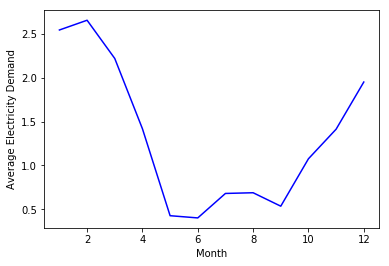

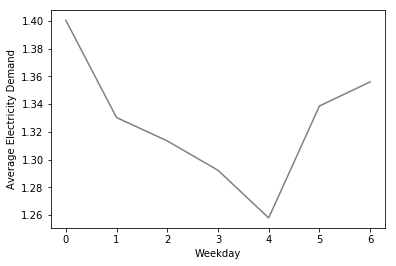

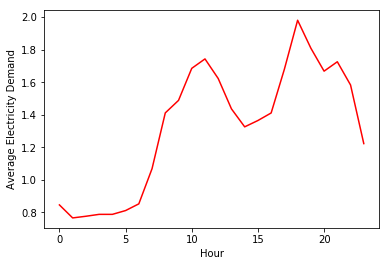

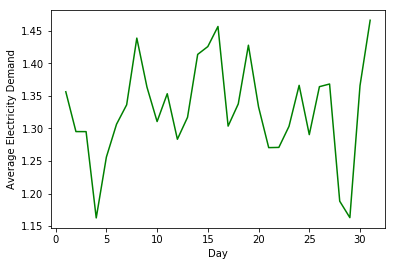

In [163]:
# Data Analysis on the original data
groupby_month = data.groupby(['month']).mean()
plt.plot(groupby_month.demand, color='blue')
plt.xlabel('Month')
plt.ylabel('Average Electricity Demand')
plt.show()

groupby_weekday = data.groupby(['weekday']).mean()
plt.plot(groupby_weekday.demand, color='gray')
plt.xlabel('Weekday')
plt.ylabel('Average Electricity Demand')
plt.show()

groupby_hour = data.groupby(['hour']).mean()
plt.plot(groupby_hour.demand, color='red')
plt.xlabel('Hour')
plt.ylabel('Average Electricity Demand')
plt.show()

groupby_day = data.groupby(['day']).mean()
plt.plot(groupby_day.demand, color='green')
plt.xlabel('Day')
plt.ylabel('Average Electricity Demand')
plt.show()

# NAIVE APPROACH

In [164]:
modelList = []
maeList = []

# Naive Method
demandArray = np.asarray(trainY.demand)
y_predicted = testY.copy()
y_predicted['baseline'] = demandArray[len(demandArray)-1]

testingError = mean_absolute_error(testY.demand, y_predicted.baseline)
print(testingError)
modelList.append("Naive");
maeList.append(testingError);

1.1347190625


# MEAN APPROACH

In [165]:
# Average Approach
y_predicted['average'] = trainY.demand.mean()
testingError = mean_absolute_error(testY.demand, y_predicted.average)
print(testingError)
modelList.append("Average");
maeList.append(testingError);

1.1044030754248457


# ROLLING AVERAGE APPROACH

In [ ]:
# Rolling Average Approach
y_predicted['movingAverage'] = trainY.demand.rolling(60).mean().iloc[-1]
testingError = mean_absolute_error(testY.demand, y_predicted.movingAverage)
print(testingError)
modelList.append("Moving Average");
maeList.append(testingError);

# SIMPLE LINEAR REGRESSION

In [167]:
# Simple Linear Regression

from sklearn import linear_model
from sklearn import preprocessing

# Preprocessing
scaler = preprocessing.StandardScaler().fit(trainX)
trainX = scaler.transform(trainX)

scaler = preprocessing.StandardScaler().fit(testX)
testX = scaler.transform(testX)

# Training
regr = linear_model.LinearRegression()
model = regr.fit(trainX, trainY.values.ravel())
trainMae = mean_absolute_error(trainY, regr.predict(trainX))
print("Train MAE: ", trainMae)

# Testing
y_predicted = regr.predict(testX)
testMae =  mean_absolute_error(testY, y_predicted)
print("Test MAE: ", testMae)

modelList.append("Linear Regression");
maeList.append(testMae);

Train MAE:  0.7467403820626826
Test MAE:  1.0951153570821364


# RANDOM FOREST

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

# Training
regr = RandomForestRegressor(max_depth=2, random_state=0)
model = regr.fit(trainX, trainY.values.ravel())
trainMae = mean_absolute_error(trainY, regr.predict(trainX))
print("Train MAE: ", trainMae)

# Testing
y_predicted = regr.predict(testX)
testMae =  mean_absolute_error(testY, y_predicted)
print("Test MAE: ", testMae)

modelList.append("Random Forest");
maeList.append(testMae);

# SARIMA

In [192]:
# SARIMA
import statsmodels.api as sm
print(trainY.index)
fit1 = sm.tsa.statespace.SARIMAX(trainY.demand).fit()
y_predicted = fit1.predict(start=34945, end=35040, dynamic=True)
testingError = mean_absolute_error(testY.demand, y_predicted)
print(testingError)
modelList.append("Arima");
maeList.append(testingError);

RangeIndex(start=0, stop=34944, step=1)
2.138920138121476


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


# FINAL RESULT

In [193]:
results = pd.DataFrame({
    'Approach': modelList,
    'Mean Absolute Error': maeList
})

results

,Approach,Mean Absolute Error
0,Naive,1.134719
1,Average,1.104403
2,Moving Average,1.183777
3,Linear Regression,1.095115
4,Random Forest,1.200945
5,Arima,2.138920
6,Arima,2.138920
